In [1]:
import sys
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn

# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the root directory
root_directory = os.path.abspath(os.path.join(current_dir, '..'))

# Add the root directory to the system path
sys.path.append(root_directory)

# Verify the path addition
from helper_utils import *

c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_heatmap(data):
    """
    Plot a heatmap from a 2D NumPy array.

    :param data: 2D NumPy array representing the heatmap data.
    """
    plt.imshow(data, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.show()

def convert_backslashes_to_forward_slashes(path):
    """
    Converts all backslashes in the given path to forward slashes.

    :param path: The file path as a string.
    :return: The modified file path with forward slashes.
    """
    return path.replace('\\', '/')

def list_files_in_folder(folder_path):
    """
    Returns a list of paths to all files in the given folder.

    :param folder_path: Path to the folder.
    :return: List of file paths.
    """
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

In [3]:
paths =  list_files_in_folder(convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Heidelberg_hackaton\CellTrackingU-Net\data\train\PhC-C2DH-U373\01_ST'))
paths_imgs =  list_files_in_folder(convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Heidelberg_hackaton\CellTrackingU-Net\data\train\PhC-C2DH-U373\01'))
paths_GT =  list_files_in_folder(convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Heidelberg_hackaton\CellTrackingU-Net\data\train\PhC-C2DH-U373\01_GT\TRA'))

In [4]:
len(paths)

115

In [5]:
paths_GT = paths_GT[1:]
len(paths_GT)

115

In [6]:
paths_GT[0]

'C:/Users/Dell/Documents/Heidelberg_hackaton/CellTrackingU-Net/data/train/PhC-C2DH-U373/01_GT/TRA\\man_track000.tif'

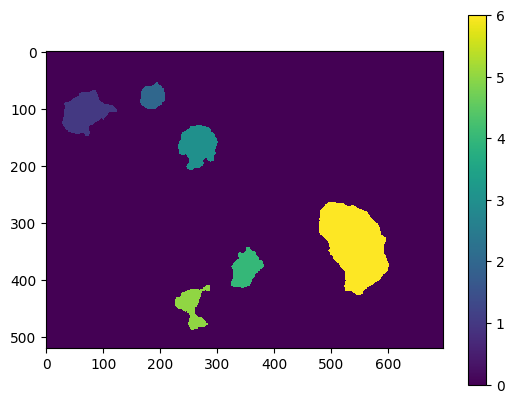

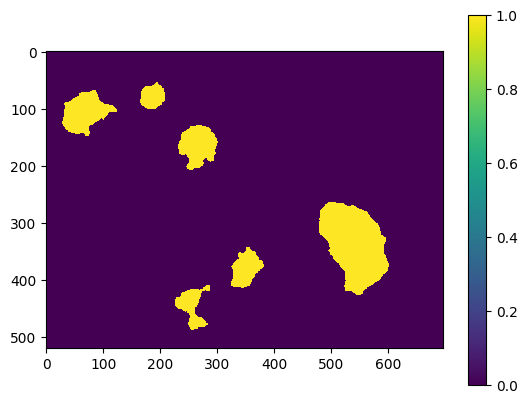

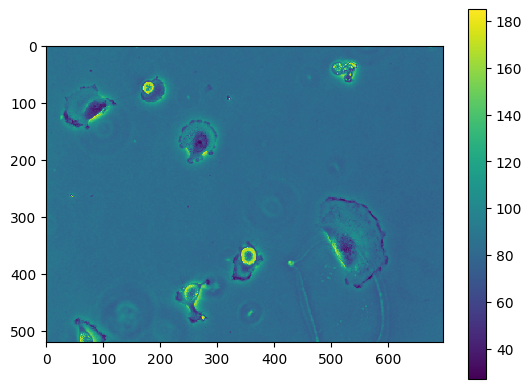

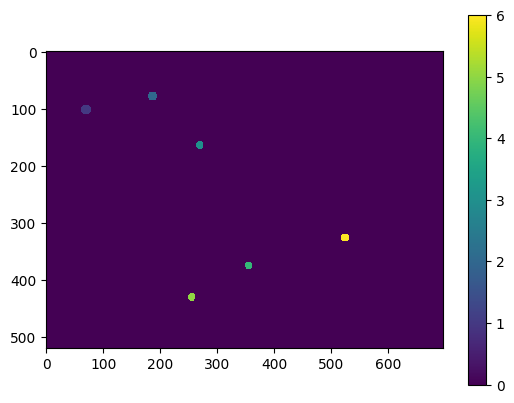

In [7]:
i = 6
image = Image.open(paths[i])
image_array = np.array(image)
image2 = Image.open(paths_imgs[i])
image_array2 = np.array(image2)
image3 = Image.open(paths_GT[i])
image_array3 = np.array(image3)
img = np.where(image_array != 0, 1, image_array)
plot_heatmap(image_array)
plot_heatmap(img)
plot_heatmap(image_array2)
plot_heatmap(image_array3)

In [8]:
class TIF_dataset(Dataset):

    def __init__(self, path_list_data, path_list_label, transform=None):
        """

        All of our data is in the same format. I sugest using the silver truths as they are in the format ideal for training.
        I dont understand how the golden truths are suposed to work, we need to look into that. (especialy in the file PhC-C2DH-U373)

        Arguments:
            path_list_data: list of paths to tif files that will be datapoints
            path_list_label: list of paths to tif files that will be labels
            transform (callable, optional): Optional transform to be applied
                on a sample.

        Returns : a pair of tensors of shape (1, W, H), coresponding to data and label
        """
        self.path_list_data = path_list_data
        self.path_list_label = path_list_label
        self.transform = transform

    def __len__(self):
        return len(self.path_list_data)

    def __getitem__(self, idx):
        image = Image.open(self.path_list_data[idx])
        image_np = np.array(image)
        label = Image.open(self.path_list_label[idx])
        label_np = np.array(label)
        label_np = np.where(label_np != 0, 1, label_np)

        image_tensor = torch.from_numpy(image_np).unsqueeze(0)
        label_tensor = torch.from_numpy(label_np).unsqueeze(0)

        image_tensor = image_tensor.float() / np.mean(image_np) #normalizing the image tensor
        label_tensor = label_tensor.float()


        if self.transform:
            image_tensor = self.transform(image_tensor)
            label_tensor = self.transform(label_tensor)

        return image_tensor, label_tensor

In [9]:
paths_x =  list_files_in_folder(convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Heidelberg_hackaton\CellTrackingU-Net\data\train\DIC-C2DH-HeLa\01'))
paths_y =  list_files_in_folder(convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Heidelberg_hackaton\CellTrackingU-Net\data\train\DIC-C2DH-HeLa\01_ST'))

dataset = TIF_dataset(paths_x, paths_y)

In [17]:
data, label = dataset[54]
# plot_heatmap(data.squeeze().numpy())
# plot_heatmap(label.squeeze().numpy())

In [40]:
label.shape

torch.Size([1, 512, 512])

In [ ]:
def channel_comparison(tensor):
    """
    Compare the two channels of the input tensor and return a numpy array with 1 where the second channel
    has a greater value than the first channel and 0 otherwise.

    Args:
    tensor (torch.Tensor): Input tensor of shape (1, 2, 512, 512).

    Returns:
    numpy.ndarray: Output array of shape (512, 512) with 1s and 0s.
    """
    if tensor.shape != (1, 2, 512, 512):
        raise ValueError("Input tensor must have shape (1, 2, 512, 512)")

    # Extract the first and second channels
    first_channel = tensor[0, 0, :, :]
    second_channel = tensor[0, 1, :, :]

    # Compare the values
    comparison_result = (second_channel > first_channel).numpy().astype(np.uint8)

    return comparison_result

In [102]:
class Convolutional_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride = 1, dropout = 0.1):
        super(Convolutional_Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn3 = nn.BatchNorm2d(num_features=out_channels)
        self.dropout = nn.Dropout(p=dropout, inplace=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.conv1(x))))
        residual = x
        x = self.dropout(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout(self.relu(self.bn3(self.conv3(x))))
        x = x + residual
        return x
    

class UNet(nn.Module):
    def __init__(self, list_of_chanel_numbers):
        super(UNet, self).__init__()
        self.list_of_chanel_numbers = list_of_chanel_numbers
        self.channel_pairs = [(list_of_chanel_numbers[i], list_of_chanel_numbers[i+1]) for i in range(len(list_of_chanel_numbers) - 1)]
        self.bottom_path = nn.ModuleList()
        self.top_path = nn.ModuleList()
        self.UpConvs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2)
        for pair in self.channel_pairs:
            c_in, c_out = pair
            self.bottom_path.append(Convolutional_Block(c_in, c_out))
        self.bottom_block = Convolutional_Block(list_of_chanel_numbers[-1], list_of_chanel_numbers[-1])
        self.channel_pairs[0] = (2, list_of_chanel_numbers[1]) # I want the model to return a tensor of shape 2 x H x W, because we want to predict only two classes
        self.channel_pairs.reverse()
        for pair in self.channel_pairs:
            c_out, c_in = pair
            self.UpConvs.append(torch.nn.ConvTranspose2d(c_in, c_in, kernel_size = 2, stride = 2, ))
            self.top_path.append(Convolutional_Block(c_in, c_out))

    def forward(self, x):
        residuals = []
        for i, module in enumerate(self.bottom_path):
            # print(f'starting to process module {i}, x.shape = {x.shape}')
            x = module(x)
            residuals.append(x)
            if i < len((self.bottom_path)):
                # print(f'POOOOOOLING {i}')
                x = self.pool(x)
            # residuals.append(x)
            # print(f'Finished processing module {i}, x.shape = {x.shape}')

        residuals.reverse()
        x = self.bottom_block(x)
        # print(f'bottom path over, x.shape: {x.shape}')

        for i, module in enumerate(self.top_path):
            # print(f'starting to process module {i}, x.shape = {x.shape}')
            if i >= 0:
                # print(f'UP CONV: x.shape before: {x.shape}')
                x = self.UpConvs[i](x)
                # print(f'UP CONV: x.shape after : {x.shape}')
            x = x + residuals[i]
            x = module(x)
            # print(f'Finished processing module {i}, x.shape = {x.shape}')
            
        return x
    
    def generate_numpy_output_from_single_image(self, img):
        '''
        Args: img: a tensor of shape (1, 2, 512, 512). It is suposed to be the output of the model. This function will turn it 
        into a numpy array of shape (512, 512) ready to be plotted.
        '''
        model_return_numpy = channel_comparison(img)
        return model_return_numpy

In [93]:
list = [1, 8, 16, 32, 64, 128]
unet_test = UNet(list)
plswork = unet_test(data.unsqueeze(dim = 0))

In [94]:
plswork_np = unet_test.generate_numpy_output_from_single_image(plswork)

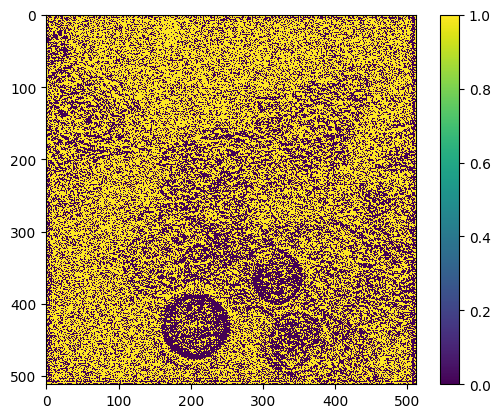

In [95]:
plot_heatmap(plswork_np)

In [32]:
plswork.shape

torch.Size([1, 2, 512, 512])

In [103]:
sizes = [1, 8, 16, 32, 64, 128]
model = UNet(sizes)

train_dataloader = DataLoader(dataset, batch_size=20, shuffle=True)
epochs = 3

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

In [105]:
def Train_Unet(train_dataloader, epochs, model,
                optimizer = None,
                loss_fn = torch.nn.CrossEntropyLoss()):
    model = model
    if optimizer == None:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    for epoch in range(epochs):
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            labels = labels.squeeze().long()
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            loss.backward()

            optimizer.step()
            print(f'BATCH: {i}, LOSS: {loss}')
        print(f'End of epoch {epoch}')
    return model

In [109]:
model = Train_Unet(train_dataloader, 4, model)

BATCH: 0, LOSS: 0.7783091068267822
BATCH: 1, LOSS: 0.7809937596321106
BATCH: 2, LOSS: 0.7777011394500732
BATCH: 3, LOSS: 0.7733708620071411
BATCH: 4, LOSS: 0.7701989412307739
End of epoch 0
BATCH: 0, LOSS: 0.7710047960281372
BATCH: 1, LOSS: 0.753667414188385
BATCH: 2, LOSS: 0.7582958936691284
BATCH: 3, LOSS: 0.7530902624130249
BATCH: 4, LOSS: 0.7368044853210449
End of epoch 1
BATCH: 0, LOSS: 0.7373102903366089
BATCH: 1, LOSS: 0.7456726431846619
BATCH: 2, LOSS: 0.7345361709594727
BATCH: 3, LOSS: 0.7494820356369019
BATCH: 4, LOSS: 0.7299805283546448
End of epoch 2
BATCH: 0, LOSS: 0.7321566343307495
BATCH: 1, LOSS: 0.7314255833625793
BATCH: 2, LOSS: 0.7190269231796265
BATCH: 3, LOSS: 0.7312866449356079
BATCH: 4, LOSS: 0.7279704213142395
End of epoch 3


In [110]:
type(model)

__main__.UNet

Model output


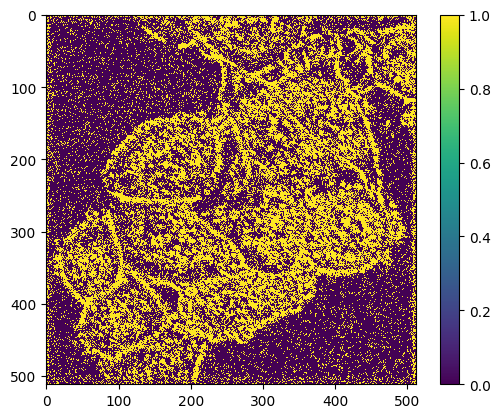

Label


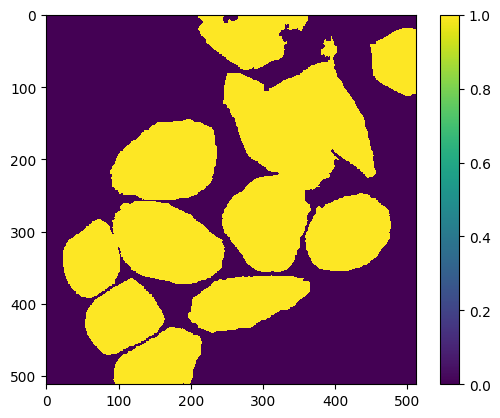

original image


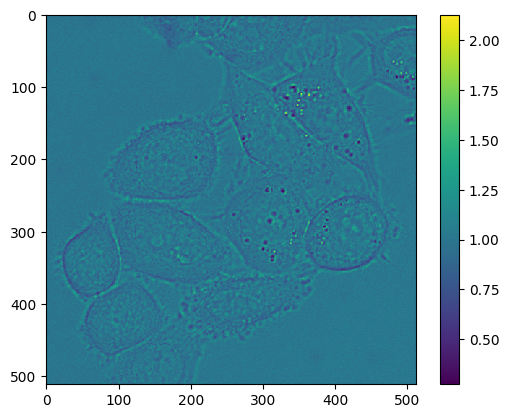

In [112]:
data, label = dataset[24]
output = model(data.unsqueeze(dim = 0))
model_return_numpy = channel_comparison(output)
print('Model output')
plot_heatmap(model_return_numpy)
print('Label')
plot_heatmap(label.squeeze().numpy())
print('original image')
plot_heatmap(data.squeeze().numpy())

In [74]:
paths_x_test =  list_files_in_folder(convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Heidelberg_hackaton\CellTrackingU-Net\data\test\DIC-C2DH-HeLa\01'))
paths_y_test =  list_files_in_folder(convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Heidelberg_hackaton\CellTrackingU-Net\data\test\DIC-C2DH-HeLa\01'))

test_dataset = TIF_dataset(paths_x_test, paths_y_test)

Model output


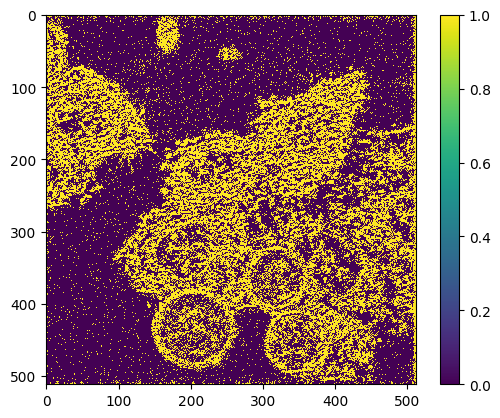

original image


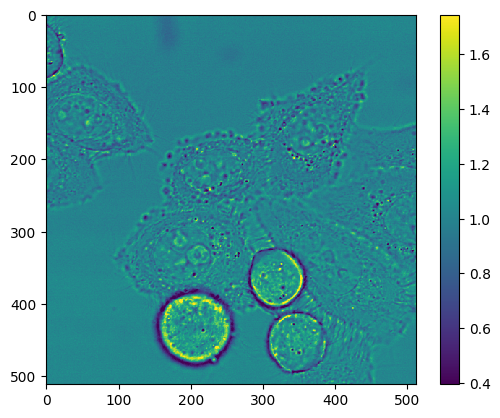

In [80]:
# Ploting the results on a test dataset:

data, label = test_dataset[6]
output = model(data.unsqueeze(dim = 0))
model_return_numpy = channel_comparison(output)
print('Model output')
plot_heatmap(model_return_numpy)
print('original image')
plot_heatmap(data.squeeze().numpy())